# Homework 5

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Задача №1 - Можете ли вы отличить сорняки от рассады?

Теперь приступим к задаче классификации на картинках. Реализуйте программу, которая определяет тип рассады на изображении. 

Для того, чтобы определить характерные особенности каждого типа рассады, у вас есть train. Train это папка, в которой картинки уже классифицированы и лежат в соответствующих папках. Исходя из этой информации можете найти признаки, присущие конкретному растению.

Проверка вашего решения будет на происходить на test. В папке test уже нет метки класса для каждой картинки. 

[Ссылка на Яндекс-диск](https://yadi.sk/d/0Zzp0klXT0iRmA), все картинки тут.

Примеры изображений для теста:
<table><tr>
    <td> <img src="https://i.ibb.co/tbqR37m/fhj.png" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/6yL3Wmt/sfg.png" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/pvn7NvF/asd.png" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

In [2]:
def add_to_train(train):
    new_train = []
    for i in range(len(train)):
        new_train.append([])
        for im in train[i]:
            new_train[-1].append(im.copy())
            new_train[-1].append(cv2.flip(im.copy(), 0).astype(np.uint8))
    return new_train

In [3]:
def transform(image):
    im = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    h_im = im[:,:,0]
    h1 = h_im < 30
    h2 = h_im > 90
    
    v = im[:,:,2] > 150
    s = im[:,:,1] < 100
    im[:,:][h1 | h2 | v | s] = [0, 0, 0]
    
#     im[:,:][h1 | h2] = [0, 0, 0]
    return cv2.cvtColor(im, cv2.COLOR_HSV2RGB)

In [4]:
def spec_points(image):
    im = transform(image)
    hyp_params = dict(
        nfeatures = 100,
        nOctaveLayers = 10,
        contrastThreshold = 0.05,
        edgeThreshold = 4,
        sigma = 4.0)  # hyp params
    detector = cv2.xfeatures2d.SIFT_create(**hyp_params)

    _, desc = detector.detectAndCompute(im, None)
    return desc.astype(np.float32)

In [ ]:
# def identification(old_train, test, names):
#     ratio_thresh = 0.7
#     FLANN_INDEX_KDTREE = 2
#     index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
#     search_params = dict(checks=50)

#     flann = cv2.FlannBasedMatcher(index_params, search_params)
    
#     descs = []
#     for i in range(len(train)):
#         descs.append([])
#         for im in train[i]:
#             descs[-1].append(spec_points(im))
            
#     inds_res = []
#     inds_res2 = []
#     for im in test:

#         test_desc = spec_points(im)

#         max_num = 0
#         ind_res = 0
#         ind_res2 = 0
#         min_dist = -1
#         for ind, descsi in enumerate(descs):
#             m_num = 0
#             m_dist = -1
#             for desc in descsi:
#                 matches = flann.knnMatch(test_desc, desc, k=2)
#                 num = 0
#                 dist = 0
#                 for m, n in matches:
#                     if m.distance < ratio_thresh * n.distance:
#                         num += 1
#                         dist += m.distance
                
#                 if num and (m_dist > dist or m_dist==-1):
#                     m_dist = dist/num
                            
#                 if m_num < num:
#                     m_num = num
                    
                    
#             if m_num < min_dist or min_dist==-1 :
#                 min_dist = m_dist
#                 ind_res2 = ind
                
#             if m_num > max_num:
#                 max_num = m_num
#                 ind_res = ind
#         inds_res.append(ind_res)
#         inds_res2.append(ind_res2)
#     return inds_res, inds_res2

In [5]:
# def identification(old_train, test, names):
#     ratio_thresh = 0.7
    
#     train = add_to_train(old_train)
    
#     descs = []
#     for i in range(len(train)):
#         descs.append([])
#         for im in train[i]:
#             descs[-1].append(spec_points(im))
            
#     inds_res = []
#     for im in test:
#         FLANN_INDEX_KDTREE = 2
#         index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
#         search_params = dict(checks=50)

#         flann = cv2.FlannBasedMatcher(index_params, search_params)
#         test_desc = spec_points(im)

#         max_num = 0
#         ind_res = 0
#         for ind, descsi in enumerate(descs):
#             m_num = 0
#             for desc in descsi:
#                 matches = flann.knnMatch(desc, test_desc, k=2)
#                 num = 0
#                 for m, n in matches:
#                     if m.distance < ratio_thresh * n.distance:
#                         num += 1
#                 if m_num < num:
#                     m_num = num
#             if m_num > max_num:
#                 max_num = m_num
#                 ind_res = ind
#         inds_res.append(ind_res)
#     return inds_res

In [6]:
def identification(old_train, test, names):
    ratio_thresh = 0.7
    
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    train = add_to_train(old_train)
    print(len(train[0]))
    
    inds_res = [0]*len(test)
    max_num = [0]*len(test)
    
    for j, im in enumerate(test):
        test_desc = spec_points(im)
        
        for i in range(len(train)):
            descs = []
            m_num = 0
            for im in train[i]:
                desc = spec_points(im)
                matches = flann.knnMatch(desc, test_desc, k=2)
                num = 0
                for m, n in matches:
                    if m.distance < ratio_thresh * n.distance:
                        num += 1
                if m_num < num:
                    m_num = num
                       
            if m_num > max_num[j]:
                max_num[j] = m_num
                inds_res[j] = i
    return inds_res

In [16]:
n = 40
inds_res = identification(train, test[:n], names)
print(inds_res)
print(res[:n])
err = 0
for i in range(len(inds_res)):
    if inds_res[i] != res[i]:
        err += 1
print(err)

10
[0, 0, 3, 1, 0, 2, 3, 3, 3, 0, 1, 1, 2, 3, 2, 3, 2, 3, 2, 3, 2, 2, 3, 3, 3, 2, 2, 0, 3, 3, 0, 2, 0, 0, 3, 0, 3, 0, 1, 2]
[0, 0, 1, 1, 0, 0, 0, 3, 1, 0, 1, 1, 0, 3, 2, 3, 2, 3, 0, 3, 2, 2, 3, 1, 3, 2, 2, 1, 3, 3, 0, 2, 0, 0, 1, 2, 3, 2, 1, 1]
12


In [8]:
def get_test():
    path = "./plants/test/"
    test = []
    for path_im in os.listdir(path):
        test.append(cv2.imread(path+path_im))
    return test

In [9]:
def get_train():
    path = "./plants/train/"
    names = os.listdir(path)
    train = []
    for name in names:
        train.append([])
        for path_im in os.listdir(path+name):
            train[-1].append(cv2.imread(path+name+'/'+path_im))
    return names, train

In [10]:
names, train = get_train()
test = get_test()

In [11]:
max_len = 0
for i in range(len(train)):
    max_len = len(train[i]) if len(train[i]) > max_len else max_len

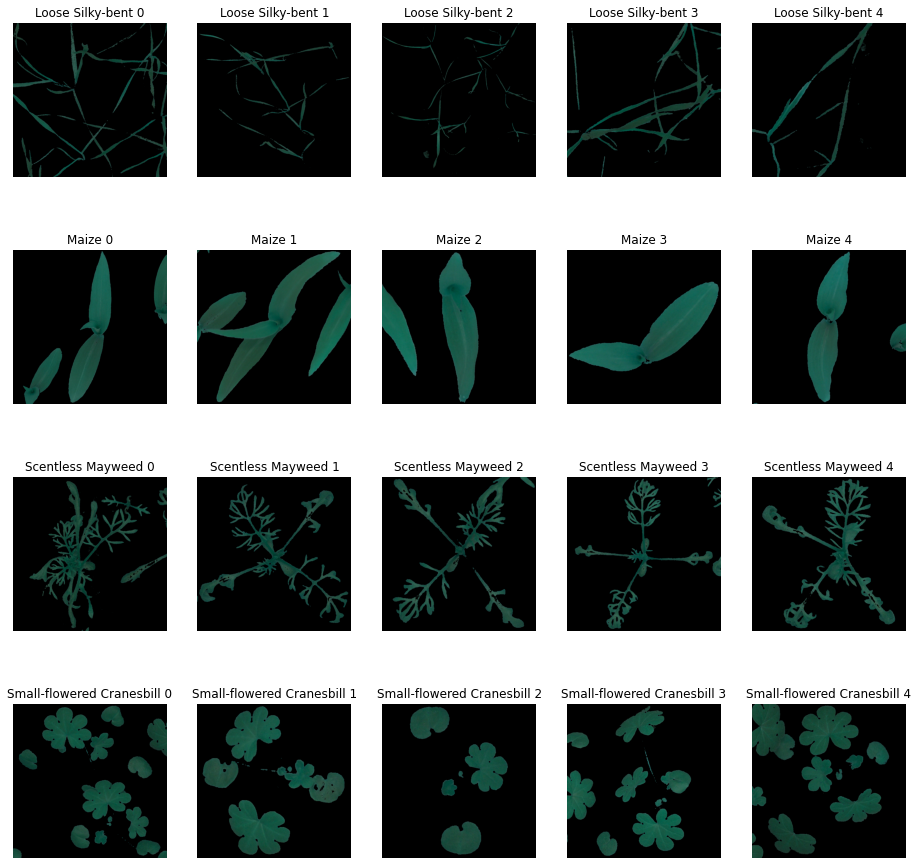

In [12]:
fig, axes = plt.subplots(len(train), max_len, figsize=(16, 16))

for i in range(len(train)):
    for j in range(len(train[i])):
        axes[i][j].imshow(transform(train[i][j]))
        axes[i][j].set_title(f'{names[i]} {j}')
        axes[i][j].axis('off')

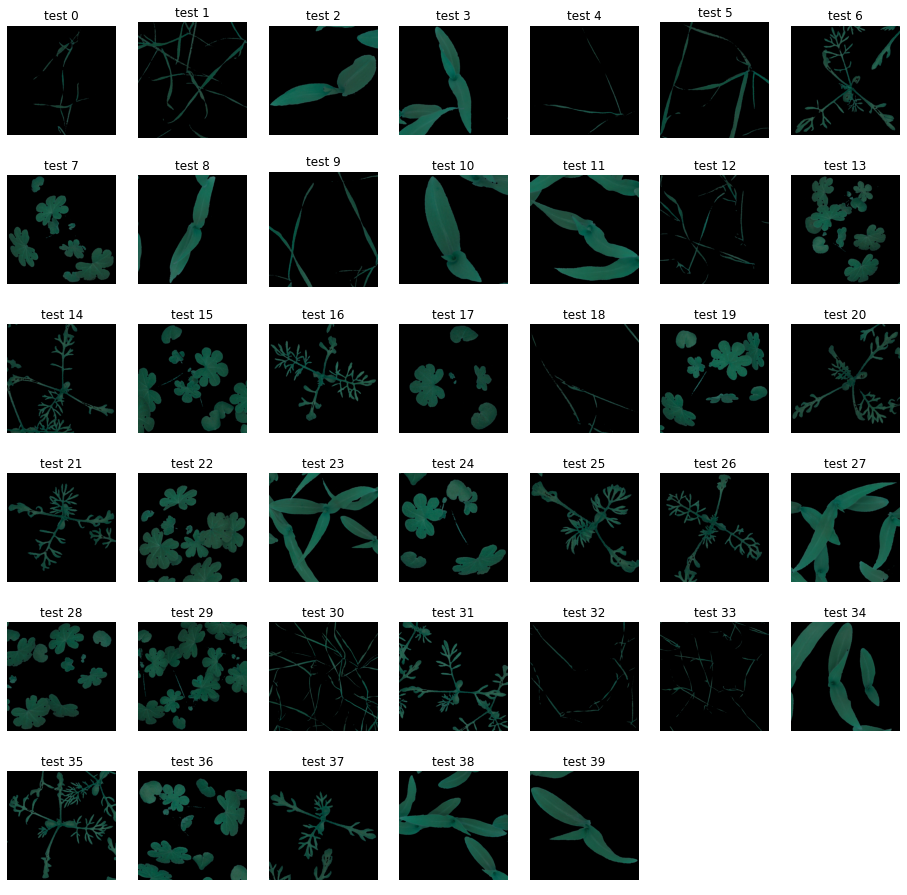

In [13]:
a = int(np.sqrt(len(test)))
fig, axes = plt.subplots(a, len(test)//a+1, figsize=(16, 16))
axes = axes.ravel()

for i in range(len(test)):
    axes[i].imshow(transform(test[i]))
    axes[i].set_title(f'test {i}')
    
for ax in axes:
    ax.axis('off')

In [14]:
res = [0, 0, 1, 1, 0, 0, 0, 3, 1, 0, 1, 1, 0, 3, 2, 3, 2, 3, 0, 3, 2, 2, \
       3, 1, 3, 2, 2, 1, 3, 3, 0, 2, 0, 0, 1, 2, 3, 2, 1, 1]
len(res)

40

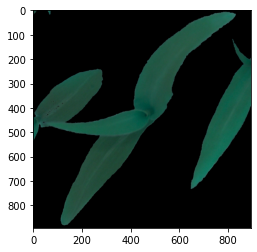

In [15]:
im = transform(train[1][1])
plt.imshow(im)

# Задача №2 - Собери пазл (2.0).

Даны кусочки изображения, ваша задача склеить пазл в исходную картинку. 

Условия:
* Дано исходное изображение для проверки, использовать собранное изображение в самом алгоритме нельзя;
* Картинки имеют друг с другом пересечение;
* После разрезки кусочки пазлов не были повернуты или отражены;
* НЕЛЬЗЯ выбрать опорную картинку для сбора пазла, как это было в homework 3
* В процессе проверки решения пазлы могут быть перемешаны, т.е. порядок пазлов в проверке может отличаться от исходного 

Изображения расположены по [ссылке](https://disk.yandex.ru/d/XtpawH1sV9UDlg).

Примеры изображений:
<img src="puzzle/su_fighter.jpg" alt="Drawing" style="width: 300px;"/>
<table><tr>
    <td> <img src="puzzle/su_fighter_shuffle/0.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="puzzle/su_fighter_shuffle/1.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="puzzle/su_fighter_shuffle/2.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="puzzle/su_fighter_shuffle/3.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

In [ ]:
# Ваш код

In [57]:
im = np.array([[[255,255,255],[255,255,255]], [[255,255,255], [255,255,255]]], dtype=np.uint8)
cv2.cvtColor(im, cv2.COLOR_RGB2HSV)

array([[[  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255]]], dtype=uint8)